# PCA vs HOPCA

I will write the comments in italian because I truly believe that very few people other than me will read it. If this is an issue tell me and I will translate everything

## Scopo

Lo scopo e' quello di confrontare PCA con la sua versione tensoriale. Questo notebook parte come un proof of concept, quindi per ora lo faccio per 1 solo numero di reynolds (8000) con forte subsampling e vedo se ci sono differenze

In [18]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
import h5py
from tqdm import tqdm
import pandas as pd


In [19]:
n_snapshots = 200
subsample_x = 10
subsample_y = 10
paths = ["sharmapushan/hydrogen-jet-8000"]
data_paths = [kagglehub.dataset_download(name) for name in paths]
# Load metadata
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)

Nx, Ny = metadata['global']['Nxyz']

# Load grid
X_filename = metadata['global']['grid']['x']
Y_filename = metadata['global']['grid']['y']
X = np.fromfile(data_paths[0] + '/' + X_filename, dtype='<f4').reshape(Ny, Nx)
Y = np.fromfile(data_paths[0] + '/' + Y_filename, dtype='<f4').reshape(Ny, Nx)

# Subsample grid
X_sub = X[::subsample_x, ::subsample_y]
Y_sub = Y[::subsample_x, ::subsample_y]
Ny_sub, Nx_sub = X_sub.shape

print(f"Original grid: ({Nx}, {Ny})")
print(f"Subsampled grid: ({Nx_sub}, {Ny_sub})")

Original grid: (1600, 2000)
Subsampled grid: (160, 200)


In [20]:
component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']

# Molar masses (g/mol)
molar_masses = {
    'YH': 1.0,
    'YH2': 2.0,
    'YO': 8.0,
    'YO2': 16.0,
    'YOH': 9.0,
    'YH2O': 10.0,
    'YHO2': 17.0,
    'YH2O2': 18.0
}


file_key_map = {
    'YH': 'YH filename',
    'YH2': 'YH2 filename',
    'YO': 'YO filename',
    'YO2': 'YO2 filename',
    'YOH': 'YOH filename',
    'YH2O': 'YH2O filename',
    'YHO2': 'YHO2 filename',
    'YH2O2': 'YH2O2 filename'
}

In [21]:
# Load Snapshot Data
def load_dataset(data_path, component_names, file_key_map, Ny, Nx, subsample_x, subsample_y):
    with open(f"{data_path}" + '/info.json', 'r') as f:
        metadata = json.load(f)

    # Sta roba da quando facevo il caso non reattivo
    available_components = []
    available_indices = []
    for c_idx, comp_name in enumerate(component_names):
        filename_key = file_key_map[comp_name]
        if filename_key in metadata['local'][0]:
            available_components.append(comp_name)
            available_indices.append(c_idx)

    print(f"  Available components in dataset: {available_components}")
    n_available = len(available_components)

    # Initialize tensor with only available components: (x, y, components, time)
    tensor = np.zeros((Ny_sub, Nx_sub, n_available, n_snapshots))
    for t_idx in range(n_snapshots):
        for new_idx, (comp_name, orig_idx) in enumerate(zip(available_components, available_indices)):
            filename_key = file_key_map[comp_name]
            filename = metadata['local'][t_idx][filename_key]
            data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
            # Convert mass fraction to molar fraction by dividing by molar mass
            molar_data = data / molar_masses[comp_name]
            tensor[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]

    return tensor
tensors = {path: load_dataset(path, component_names, file_key_map, Ny, Nx, subsample_x, subsample_y)
           for path in data_paths}

  Available components in dataset: ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']



Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Component       Mean         Std          Min          Max         
--------------------------------------------------------------------------------
YH              2.108595e-04 4.958064e-04 -4.988369e-25 4.876255e-03
YH2             3.141716e-02 8.368027e-02 0.000000e+00 3.249700e-01
YO              8.207165e-05 2.683234e-04 -1.025646e-14 1.899564e-03
YO2             1.125224e-02 5.756119e-03 1.262478e-07 1.456250e-02
YOH             1.605751e-04 5.228729e-04 -1.954558e-11 3.019940e-03
YH2O            3.061480e-03 6.672779e-03 -2.330029e-07 2.365345e-02
YHO2            2.972886e-07 8.293629e-07 -2.481960e-17 1.084706e-05
YH2O2           1.741783e-08 4.961067e-08 -8.167948e-13 7.718936e-07
--------------------------------------------------------------------------------
Overall Tensor Statistics:
  Shape: (200, 160, 8, 200)
  Total elements: 51,200,000
  Memory size: 390.62 MB
  Global mean: 5.773

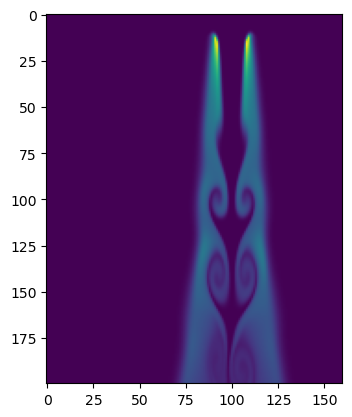

In [22]:
plt.imshow(tensors['/home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3'][:,:, 0, 10])

for dataset_path, tensor in tensors.items():
    if "nonreact" not in dataset_path:
        print("\n" + "=" * 80)
        print(f"Dataset: {dataset_path}")
        print("=" * 80)
        print(f"{'Component':<15} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
        print("-" * 80)        
        for c_idx, comp_name in enumerate(component_names):
            component_data = tensor[:, :, c_idx, :]
            mean_val = np.mean(component_data)
            std_val = np.std(component_data)
            min_val = np.min(component_data)
            max_val = np.max(component_data)
            
            print(f"{comp_name:<15} {mean_val:<12.6e} {std_val:<12.6e} {min_val:<12.6e} {max_val:<12.6e}")
        
        print("-" * 80)
        
        # Overall tensor stats
        print(f"Overall Tensor Statistics:")
        print(f"  Shape: {tensor.shape}")
        print(f"  Total elements: {tensor.size:,}")
        print(f"  Memory size: {tensor.nbytes / (1024**2):.2f} MB")
        print(f"  Global mean: {np.mean(tensor):.6e}")
        print(f"  Global std:  {np.std(tensor):.6e}")
        print(f"  Global min:  {np.min(tensor):.6e}")
        print(f"  Global max:  {np.max(tensor):.6e}")
        print("=" * 80)


## Preprocessing

Visto che sto lavorando solo con specie chimiche riscalo con logaritmo, dividere per la varianza mi sembra un po' sospetto. Per centrare i dati prendo la media dei valori non nulli.

In [23]:
component_means_all = {}
epsilon = 1e-12  

for dataset_path, tensor in tensors.items():
    
    print("\n" + "=" * 50)
    print(f"Dataset: {dataset_path}")
    print("Applying log scaling and centering to chemical species...")
    print("=" * 50)
    print(f"{'Component':<15} {'Mean (after log)':<20} {'Std':<15} {'Max (log)':<15}")
    print("-" * 70)
    
    n_components = tensor.shape[2]
    
    for c_idx, comp_name in enumerate(component_names):        
        component_data = tensor[:, :, c_idx, :]

        component_data = np.log10(np.clip(component_data, 0, None) + 1e-12)
        mask = component_data > np.log10(1e-12)
        mean_val = np.mean(component_data[mask])
        component_data -= mean_val
        std_val = np.std(component_data)
        #component_data = (component_data - mean_val) 

        tensor[:, :, c_idx, :] = component_data
        component_means_all[comp_name] = {
            "mean_after_log": mean_val,
            "std_after_log": std_val
        }

        print(f"{comp_name:<15} {mean_val:<20.3e} {std_val:<15.3e} {component_data.max():<15.3e}")

print("\nLog scaling and centering complete.\n")



Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Applying log scaling and centering to chemical species...
Component       Mean (after log)     Std             Max (log)      
----------------------------------------------------------------------
YH              -8.038e+00           3.768e+00       5.726e+00      
YH2             -6.747e+00           4.351e+00       6.259e+00      
YO              -9.328e+00           3.343e+00       6.607e+00      
YO2             -2.310e+00           9.945e-01       4.729e-01      
YOH             -8.069e+00           3.508e+00       5.549e+00      
YH2O            -6.368e+00           4.309e+00       4.741e+00      
YHO2            -9.154e+00           2.578e+00       4.189e+00      
YH2O2           -9.428e+00           1.972e+00       3.316e+00      

Log scaling and centering complete.




Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
Component       Mean         Std          Min          Max         
--------------------------------------------------------------------------------
YH              -1.169999e+00 3.767750e+00 -3.962388e+00 5.725698e+00
YH2             -9.744041e-01 4.351006e+00 -5.253304e+00 6.258540e+00
YO              -1.734036e-02 3.343187e+00 -2.672115e+00 6.606539e+00
YO2             7.613465e-17 9.944892e-01 -4.589128e+00 4.728808e-01
YOH             -1.117300e+00 3.508285e+00 -3.931154e+00 5.548845e+00
YH2O            -2.244309e+00 4.309390e+00 -5.632469e+00 4.741426e+00
YHO2            -8.023845e-01 2.578418e+00 -2.846332e+00 4.188980e+00
YH2O2           -1.176194e+00 1.972025e+00 -2.572032e+00 3.315526e+00
--------------------------------------------------------------------------------
Overall Tensor Statistics:
  Shape: (200, 160, 8, 200)
  Total elements: 51,200,000
  Memory size: 390.62 MB
  Global me

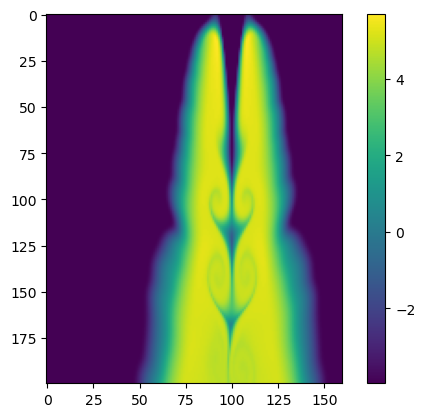

In [24]:
plt.imshow(tensors['/home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3'][:,:, 0, 10])
plt.colorbar()
for dataset_path, tensor in tensors.items():
    if "nonreact" not in dataset_path:
        print("\n" + "=" * 80)
        print(f"Dataset: {dataset_path}")
        print("=" * 80)
        print(f"{'Component':<15} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
        print("-" * 80)        
        for c_idx, comp_name in enumerate(component_names):
            component_data = tensor[:, :, c_idx, :]
            mean_val = np.mean(component_data)
            std_val = np.std(component_data)
            min_val = np.min(component_data)
            max_val = np.max(component_data)
            
            print(f"{comp_name:<15} {mean_val:<12.6e} {std_val:<12.6e} {min_val:<12.6e} {max_val:<12.6e}")
        
        print("-" * 80)
        
        # Overall tensor stats
        print(f"Overall Tensor Statistics:")
        print(f"  Shape: {tensor.shape}")
        print(f"  Total elements: {tensor.size:,}")
        print(f"  Memory size: {tensor.nbytes / (1024**2):.2f} MB")
        print(f"  Global mean: {np.mean(tensor):.6e}")
        print(f"  Global std:  {np.std(tensor):.6e}")
        print(f"  Global min:  {np.min(tensor):.6e}")
        print(f"  Global max:  {np.max(tensor):.6e}")
        print("=" * 80)
